In [1]:
import argparse
import os
from data import CIFAR10Dataset, Imagenet32Dataset
from models.embedders import BERTEncoder, OneHotClassEmbedding, UnconditionalClassEmbedding, GPTEncoder
import torch
from models.cgan import CDCGAN_G, CDCGAN_D
from torch.optim import lr_scheduler
import time
from tqdm import tqdm
from tensorboardX import SummaryWriter
import numpy as np
import torchvision.utils as vutils

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passi

In [3]:
%reload_ext autoreload
%autoreload 2
from utils.evalutils import sample_image, sample_final, load_model, sample_for_inception
from inception import inception_score

# Setup

In [5]:
# setting params
batch_size = 32
use_cuda = 1
n_filters=128
z_dim=100
output_dir="outputs/cgan_cifar10"
model_checkpoint="outputs/cgan_cifar10/models/epoch_81.pt"
print_every=10
dataset="cifar10"
conditioning="bert"
device = torch.device("cuda") if (torch.cuda.is_available() and use_cuda) else torch.device("cpu")
# n_epochs =150
# lr=0.0001
# lr_decay=0.99
# n_cpu=8
# sample_interval=100
# eval_dir = "outputs/cgan_cifar10/eval"
# debug=0
# train_on_val=0
# train=1
#choices=["unconditional", "one-hot", "bert", "gpt"]
# setup device

In [6]:
print("Device is {}".format(device))

Device is cuda


In [7]:
# Imagenet and CIFAR dataloaders
imagenet_dataset = Imagenet32Dataset(train=0, max_size=-1)
cifar_dataset = CIFAR10Dataset(train=0, max_size=-1)
imagenet_val_dataloader = torch.utils.data.DataLoader(
    imagenet_dataset,
    batch_size,
    shuffle=True,
    drop_last=True
)
cifar_val_dataloader = torch.utils.data.DataLoader(
    cifar_dataset,
    batch_size,
    shuffle=True,
    drop_last=True
)

loading data file 1/1, datasets/ImageNet32/val/val_data.npz
Files already downloaded and verified


In [8]:
# check len
len(imagenet_val_dataloader)

1562

In [9]:
len(cifar_val_dataloader)

312

In [10]:
# Initialize embedder
unconditional_encoder = UnconditionalClassEmbedding()
bert_encoder = BERTEncoder()
gpt_encoder = GPTEncoder()

# Initialize models

In [11]:
# init generator model
# model_G = CDCGAN_G(z_dim=z_dim, embed_dim=768, n_filters=n_filters)
model_G_cifar10_baseline = CDCGAN_G(z_dim=z_dim, embed_dim=768, n_filters=n_filters)
model_G_imagenet_baseline = CDCGAN_G(z_dim=z_dim, embed_dim=768, n_filters=n_filters)
model_G_cifar10_gpt = CDCGAN_G(z_dim=z_dim, embed_dim=768, n_filters=n_filters)
model_G_cifar10_gptsigmoid = CDCGAN_G(z_dim=z_dim, embed_dim=768, n_filters=n_filters)
model_G_cifar10_wgan = CDCGAN_G(z_dim=z_dim, embed_dim=768, n_filters=n_filters)
# model_G.weight_init(mean=0.0, std=0.02)
# model_G = model_G.to(device)
# state_dict = torch.load(model_checkpoint, map_location=torch.device('cpu'))['G']

In [12]:
# model checkpoints
cgan_cifar10_baseline = "outputs/cgan_cifar10/models"
cgan_imagenet_baseline = "outputs/cgan_imagenet/models"
cgan_cifar10_gpt = "outputs/cgan_gpt/models"
cgan_cifar10_gptsigmoid = "outputs/cgan_gpt_sigmoid/models"
cgan_cifar10_wgan = "outputs/wcgan_cifar10/models"

# Sample images from most trained model

In [55]:
# sample images: baseline CIFAR
model_checkpoint = os.path.join(cgan_cifar10_baseline, "epoch_" + str(81) + ".pt")
load_model(model_checkpoint, model_G_cifar10_baseline, torch.device('cpu'))
sample_final(model_G_cifar10_baseline, bert_encoder, "outputs/cgan_cifar10",
             n_row=4, dataloader=cifar_val_dataloader, device=device)

saved  outputs/cgan_cifar10/samples/final_sample


In [56]:
# sample images: basline imagenet
model_checkpoint = os.path.join(cgan_imagenet_baseline, "epoch_" + str(7) + ".pt")
load_model(model_checkpoint, model_G_imagenet_baseline, torch.device('cpu'))
sample_final(model_G_imagenet_baseline, bert_encoder, "outputs/cgan_imagenet",
             n_row=4, dataloader=imagenet_val_dataloader, device=device)

saved  outputs/cgan_imagenet/samples/final_sample


In [60]:
# sample images: CIFAR GPT
model_checkpoint = os.path.join(cgan_cifar10_gpt, "epoch_" + str(99) + ".pt")
load_model(model_checkpoint, model_G_cifar10_gpt, torch.device('cpu'))
sample_final(model_G_cifar10_gpt, gpt_encoder, "outputs/cgan_gpt",
             n_row=4, dataloader=cifar_val_dataloader, device=device)

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


saved  outputs/cgan_gpt/samples/final_sample


In [58]:
# sample images: CIFAR GPT with sigmoid
model_checkpoint = os.path.join(cgan_cifar10_gptsigmoid, "epoch_" + str(52) + ".pt")
load_model(model_checkpoint, model_G_cifar10_gptsigmoid, torch.device('cpu'))
sample_final(model_G_cifar10_gptsigmoid, gpt_encoder, "outputs/cgan_gpt_sigmoid",
             n_row=4, dataloader=cifar_val_dataloader, device=device)

saved  outputs/cgan_gpt_sigmoid/samples/final_sample


In [65]:
# sample images: WCGAN CIFAR
model_checkpoint = os.path.join(cgan_cifar10_wgan, "epoch_" + str(92) + ".pt")
load_model(model_checkpoint, model_G_cifar10_wgan, torch.device('cpu'))
sample_final(model_G_cifar10_wgan, bert_encoder, "outputs/wcgan_cifar10",
             n_row=4, dataloader=cifar_val_dataloader, device=device)

saved  outputs/wcgan_cifar10/samples/final_sample


# Sample Images for Tier 2 Captions

In [60]:
def sample_final_test(model, encoder, output_image_dir, n_row, dataloader, device):
    """Saves single of generated imagenet pictures with caption"""
    target_dir = os.path.join(output_image_dir, "samples/")
    if not os.path.isdir(target_dir):
        os.makedirs(target_dir)

    captions = []
    gen_imgs = []
    # get sample captions
    done = False
    while not done:
        for (_, labels_batch, captions_batch) in dataloader:
            captions += captions_batch
            print(labels_batch)
            print(captions_batch)
            conditional_embeddings = encoder(labels_batch.to(device), captions)
            imgs = model.sample(conditional_embeddings).cpu()
            gen_imgs.append(imgs)

            if len(captions) > n_row ** 2:
                done = True
                break

    gen_imgs = torch.cat(gen_imgs).numpy()
    gen_imgs = np.clip(gen_imgs, 0, 1)

    fig = plt.figure(figsize=((8, 8)))
    grid = ImageGrid(fig, 111, nrows_ncols=(n_row, n_row), axes_pad=0.2)

    for i in range(n_row ** 2):
        grid[i].imshow(gen_imgs[i].transpose([1, 2, 0]))
        grid[i].set_title(captions[i])
        grid[i].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=True)

#     save_file = os.path.join(target_dir, "final_sample")
#     plt.savefig(save_file)
#     print("saved  {}".format(save_file))
#     plt.close()

tensor([635, 663, 490, 283, 708,  73, 454, 778, 243, 775, 330, 786, 361, 664,
         51, 285, 802,  98, 578, 183, 792, 830, 503,  33, 634, 526, 116, 406,
        198, 440, 108, 386])
('cicada', 'toaster', 'horned viper', 'moving van', 'shoe shop', 'mongoose', 'puffer', 'bottlecap', 'liner', 'ski mask', 'corn', 'holster', 'volcano', 'waffle iron', 'bighorn', 'recreational vehicle', 'menu', 'Japanese spaniel', 'disk brake', 'kelpie', 'trifle', 'wine bottle', 'paintbrush', 'hyena', 'mantis', 'parking meter', 'Irish water spaniel', 'partridge', 'Madagascar cat', 'albatross', 'Scotch terrier', 'goldfinch')


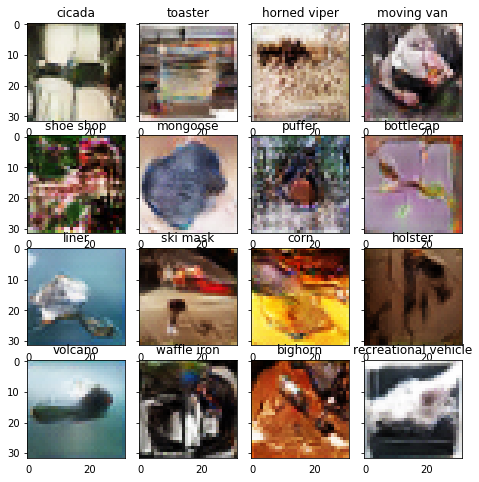

In [61]:
# sample images: baseline CIFAR
model_checkpoint = os.path.join(cgan_imagenet_baseline, "epoch_" + str(7) + ".pt")
load_model(model_checkpoint, model_G_imagenet_baseline, torch.device('cpu'))
sample_final_test(model_G_imagenet_baseline, bert_encoder, "outputs/cgan_imagenet/",
             n_row=4, dataloader=imagenet_val_dataloader, device=device)

In [79]:
import random
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
def load_vocab_imagenet(vocab_file):
    vocab = {}
    with open(vocab_file) as f:
        for l in f.readlines():
            _, id, name = l[:-1].split(" ")
            vocab[int(id) - 1] = name.replace("_", " ")
    return vocab
    
def sample_final_tier2(model, encoder, output_image_dir, n_row, caption_file, device):
    """Saves single of generated imagenet pictures with caption"""
    target_dir = os.path.join(output_image_dir, "samples/")
    if not os.path.isdir(target_dir):
        os.makedirs(target_dir)

    captions = []
    gen_imgs = []
    # get sample captions
    done = False
    while not done:
        label_to_caption_dict = load_vocab_imagenet(caption_file)
        label, caption = random.choice(list(label_to_caption_dict.items()))
        label = torch.IntTensor([label])
        caption = tuple([caption])
        print(label)
        print(caption)
        captions += caption
        conditional_embeddings = encoder(label.to(device), captions)
        imgs = model.sample(conditional_embeddings).cpu()
        gen_imgs.append(imgs)

        if len(captions) > n_row ** 2:
            done = True

    gen_imgs = torch.cat(gen_imgs).numpy()
    gen_imgs = np.clip(gen_imgs, 0, 1)

    fig = plt.figure(figsize=((8, 8)))
    grid = ImageGrid(fig, 111, nrows_ncols=(n_row, n_row), axes_pad=0.2)

    for i in range(n_row ** 2):
        grid[i].imshow(gen_imgs[i].transpose([1, 2, 0]))
        grid[i].set_title(captions[i])
        grid[i].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=True)

    save_file = os.path.join(target_dir, "final_sample_tier2")
    plt.savefig(save_file)
    print("saved  {}".format(save_file))
    plt.close()

In [82]:
# sample images: baseline CIFAR
model_checkpoint = os.path.join(cgan_imagenet_baseline, "epoch_" + str(7) + ".pt")
load_model(model_checkpoint, model_G_imagenet_baseline, torch.device('cpu'))
sample_final_tier2(model_G_imagenet_baseline, bert_encoder, "outputs/cgan_imagenet/",
             n_row=4, caption_file="map_clsloc2.txt", device=device)

tensor([527], dtype=torch.int32)
('watch',)
tensor([353], dtype=torch.int32)
('single-reed instrument',)
tensor([995], dtype=torch.int32)
('eraser',)
tensor([91], dtype=torch.int32)
('Belgian sheepdog',)
tensor([789], dtype=torch.int32)
('puzzle',)
tensor([230], dtype=torch.int32)
('lighter-than-air craft',)
tensor([356], dtype=torch.int32)
("lady's slipper",)
tensor([145], dtype=torch.int32)
('swine',)
tensor([144], dtype=torch.int32)
('retriever',)
tensor([485], dtype=torch.int32)
('python',)
tensor([238], dtype=torch.int32)
('small boat',)
tensor([801], dtype=torch.int32)
('fare',)
tensor([860], dtype=torch.int32)
('pen',)
tensor([808], dtype=torch.int32)
('cream',)
tensor([93], dtype=torch.int32)
('domestic cat',)
tensor([754], dtype=torch.int32)
('ball',)
tensor([577], dtype=torch.int32)
('hydraulic brake',)
saved  outputs/cgan_imagenet/samples/final_sample_tier2


# Calculate inception score for true data
(9.562877186875763, 0.0)

In [47]:
cifar_val_dataloader = torch.utils.data.DataLoader(
    cifar_dataset,
    100,
    shuffle=True,
    drop_last=True
)
imgs = [img for (img, labels_batch, captions_batch) in cifar_val_dataloader][0].numpy()

In [48]:
inception_score(imgs, resize = True)

(9.562877186875763, 0.0)

# Inception score for our models

In [88]:
# GPT
imgs_gpt = sample_for_inception(model_G_cifar10_gpt, gpt_encoder, 
                     100, dataloader=cifar_val_dataloader, device=device)
inception_score(imgs_gpt, resize = True)
# (3.1605518320034443, 0.0)
# size of imgs is (320,3,32,32)

(3.1198449444290364, 0.0)

In [89]:
# baseline
imgs_baseline = sample_for_inception(model_G_cifar10_baseline, bert_encoder, 
                     100, dataloader=cifar_val_dataloader, device=device)
inception_score(imgs_baseline, resize = True)
# (1.064679586315566, 0.0)

(1.0715794752322483, 0.0)

In [90]:
# wcgan
imgs_wcgan = sample_for_inception(model_G_cifar10_wgan, bert_encoder, 
                     100, dataloader=cifar_val_dataloader, device=device)
inception_score(imgs_wcgan, resize = True)

(1.0877044733992305, 0.0)

# Create real and fake images for FID Score

In [83]:
imgs_gpt = torch.from_numpy(imgs_gpt)
for i in range(10):
    utils.save_image(torch.from_numpy(imgs)[i,:,:,:], 'outputs/cgan_cifar10/fid/fake/{}.png'.format(i))

array([[[0.5228108 , 0.6939594 , 0.5351386 , ..., 0.735228  ,
         0.2523691 , 0.5607018 ],
        [0.8615374 , 0.9693105 , 0.74308896, ..., 0.79608357,
         0.34914017, 0.5783725 ],
        [0.67001426, 0.89604205, 0.4261232 , ..., 0.4967537 ,
         0.7530116 , 0.49361792],
        ...,
        [0.8692702 , 0.9874172 , 0.91087985, ..., 0.8804177 ,
         0.43202895, 0.78710884],
        [0.40895346, 0.85565776, 0.16632816, ..., 0.2758714 ,
         0.753099  , 0.1837419 ],
        [0.55043167, 0.61324185, 0.6027001 , ..., 0.50873566,
         0.68758345, 0.5578531 ]],

       [[0.5200427 , 0.8671185 , 0.19768423, ..., 0.4898375 ,
         0.45364502, 0.54957724],
        [0.44253767, 0.99113196, 0.2342307 , ..., 0.9489236 ,
         0.73177904, 0.7370488 ],
        [0.6669082 , 0.94415325, 0.47635567, ..., 0.94926786,
         0.85837674, 0.55078745],
        ...,
        [0.77550626, 0.81867766, 0.8552655 , ..., 0.9743167 ,
         0.65415   , 0.62764055],
        [0.6

In [87]:
for i in range(10):
    utils.save_image(torch.from_numpy(imgs)[i,:,:,:], 'outputs/cgan_cifar10/fid/fake/{}.png'.format(i))